# Quantum Binary classifier using Keras

###   Nikolaos Schetakis , nsxetakis@yahoo.gr

In [1]:
import pennylane as qml
import tensorflow as tf
from pennylane import numpy as np
import pandas as pd
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import AUC
from os import path

## 1. Set parameters

In [2]:
n_qubits = 2 # Number of qubits should be the same as number of features, max number = 25
LABELplot=""
blocks = 6 #number of blocks (AngleEmbedding and StronglyEntanglingLayers is one block )
layers = 1  #layers per block (multiple “layers” of StronglyEntanglingLayers per block )
learning_rate = 0.02 #Learning rate for optimizer
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate,beta_1=0.9,beta_2=0.999) #tf.keras.optimizers.SGD(learning_rate=learning_rate) #Select optimizer

epochsH = 6 # Hybrid training epochs
batch_size = 16 # Batch size
test_size = 0.2 # Choose train-test split ratio
np.random.seed(42)

## 2. Functions to generate datasets

In [3]:
#  Generate Data
N = 1200 #no of points to generate
noise = 0.01 #add noise

# Make a dataset of points inside and outside of a circle
def circle(samples, center=[0.0, 0.0], radius=np.sqrt(2 / np.pi)):
    """
    Generates a dataset of points with 1/0 labels inside a given radius.

    Args:
        samples (int): number of samples to generate
        center (tuple): center of the circle
        radius (float: radius of the circle

    Returns:
        Xvals (array[tuple]): coordinates of points
        yvals (array[int]): classification labels
    """
    Xvals, yvals = [], []

    for i in range(samples):
        x = 2 * (np.random.rand(2)) - 1
        y = 0
        if np.linalg.norm(x - center) < radius:
            y = 1
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals), np.array(yvals)


def squares(samples):
    data=[]
    Xvals, yvals = [], []
    dim=2
    for i in range(samples):
        x = 2 * (np.random.rand(dim)) - 1
        if x[0] < 0 and x[1] < 0: y = 0
        if x[0] < 0 and x[1] > 0: y = 1
        if x[0] > 0 and x[1] < 0: y = 1
        if x[0] > 0 and x[1] > 0: y = 0        
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals), np.array(yvals)  
    return data, None

def wavy_lines0(samples, freq = 1):
    Xvals, yvals = [], []
    def fun1(s):
        return s + np.sin(freq * np.pi * s)
    
    def fun2(s):
        return -s + np.sin(freq * np.pi * s)
    data=[]
    dim=2
    for i in range(samples):
        x = 2 * (np.random.rand(dim)) - 1
        if x[1] < fun1(x[0]) and x[1] < fun2(x[0]): y = 0
        if x[1] < fun1(x[0]) and x[1] > fun2(x[0]): y = 1
        if x[1] > fun1(x[0]) and x[1] < fun2(x[0]): y = 1
        if x[1] > fun1(x[0]) and x[1] > fun2(x[0]): y = 0        
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals), np.array(yvals)
    return data, freq    
    
def wavy_lines1(samples, freq = 1):
    Xvals, yvals = [], []
    def fun1(s):
        return s + np.sin(freq * np.pi * s)
    
    def fun2(s):
        return -s + np.sin(freq * np.pi * s)
    data=[]
    dim=2
    for i in range(samples):
        x = 2 * (np.random.rand(dim)) - 1
        if x[1] < fun1(x[0]) and x[1] < fun2(x[0]): y = 0
        if x[1] < fun1(x[0]) and x[1] > fun2(x[0]): y = 1
        if x[1] > fun1(x[0]) and x[1] < fun2(x[0]): y = 0
        if x[1] > fun1(x[0]) and x[1] > fun2(x[0]): y = 1        
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals), np.array(yvals)
    return data, freq    

def wavy_lines2(samples, freq = 1):
    Xvals, yvals = [], []
    def fun1(s):
        return s + np.sin(freq * np.pi * s)
    
    def fun2(s):
        return -s + np.sin(freq * np.pi * s)
    data=[]
    dim=2
    for i in range(samples):
        x = 2 * (np.random.rand(dim)) - 1
        if x[1] < fun1(x[0]) and x[1] < fun2(x[0]): y = 0
        if x[1] < fun1(x[0]) and x[1] > fun2(x[0]): y = 1
        if x[1] > fun1(x[0]) and x[1] < fun2(x[0]): y = 1
        if x[1] > fun1(x[0]) and x[1] > fun2(x[0]): y = 1        
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals), np.array(yvals)
    return data, freq    


def wavy_lines3(samples, freq = 1):
    Xvals, yvals = [], []
    def fun1(s):
        return s + np.sin(freq * np.pi * s)
    
    def fun2(s):
        return -s + np.sin(freq * np.pi * s)
    data=[]
    dim=2
    for i in range(samples):
        x = 2 * (np.random.rand(dim)) - 1
        if x[1] < fun1(x[0]) and x[1] < fun2(x[0]): y = 1
        if x[1] < fun1(x[0]) and x[1] > fun2(x[0]): y = 0
        if x[1] > fun1(x[0]) and x[1] < fun2(x[0]): y = 1
        if x[1] > fun1(x[0]) and x[1] > fun2(x[0]): y = 0        
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals), np.array(yvals)
    return data, freq    
    
    
def threecircles(samples):
    Xvals, yvals = [], []
    centers = np.array([[-1, 1], [1, 0], [-.5, -.5]])
    radii = np.array([1, np.sqrt(6/np.pi - 1), 1/2]) 
    data=[]
    dim = 2
    for i in range(samples):
        x = 2 * (np.random.rand(dim)) - 1
        y = 0
        for j, (c, r) in enumerate(zip(centers, radii)): 
            if np.linalg.norm(x - c) < r:
                y = j + 1 
                
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals), np.array(yvals)   
    
    
def _non_convex(samples, freq = 1, x_val = 2, sin_val = 1.5):
    Xvals, yvals = [], []
    def fun(s):
        return -x_val * s + sin_val * np.sin(freq * np.pi * s)
    
    data = []
    dim = 2
    for i in range(samples):
        x = 2 * (np.random.rand(dim)) - 1
        if x[1] < fun(x[0]): y = 0
        if x[1] > fun(x[0]): y = 1
        data.append([x, y])

        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals), np.array(yvals)

def _crown(samples):
    Xvals, yvals = [], []
    c = [[0,0],[0,0]]
    r = [np.sqrt(.8), np.sqrt(.8 - 2/np.pi)]
    data = []
    dim = 2
    for i in range(samples):
        x = 2 * (np.random.rand(dim)) - 1
        if np.linalg.norm(x - c[0]) < r[0] and np.linalg.norm(x - c[1]) > r[1]:
            y = 1
        else: 
            y=0
        data.append([x, y])
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals), np.array(yvals)


def _tricrown(samples):
    Xvals, yvals = [], []
    centers = [[0,0],[0,0]]
    radii = [np.sqrt(.8 - 2/np.pi), np.sqrt(.8)]
    data = []
    dim = 2
    for i in range(samples):
        x = 2 * (np.random.rand(dim)) - 1
        y=0
        for j,(r,c) in enumerate(zip(radii, centers)):
            if np.linalg.norm(x - c) > r:
                y = j + 1
        data.append([x, y])
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals), np.array(yvals)

def _sphere(samples):
    Xvals, yvals = [], []
    centers = np.array([[0, 0, 0]]) 
    radii = np.array([(3/np.pi)**(1/3)]) 
    data=[]
    dim = 3
    for i in range(samples):
        x = 2 * (np.random.rand(dim)) - 1
        y = 0
        for c, r in zip(centers, radii): 
            if np.linalg.norm(x - c) < r:
                y = 1 
                
                
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals), np.array(yvals)

def _hypersphere(samples):
    Xvals, yvals = [], []
    centers = np.array([[0, 0, 0, 0]]) 
    radii = np.array([(2/np.pi)**(1/2)]) 
    data=[]
    dim = 4
    for i in range(samples):
        x = 2 * (np.random.rand(dim)) - 1 
        y = 0
        for c, r in zip(centers, radii): 
            if np.linalg.norm(x - c) < r:
                y = 1 

        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals), np.array(yvals)
    
def plot_data(x, y, fig=None, ax=None):
    """
    Plot data with red/blue values for a binary classification.

    Args:
        x (array[tuple]): array of data points as tuples
        y (array[int]): array of data points as tuples
    """
    if fig == None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    reds = y == 0
    blues = y == 1
    ax.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
    ax.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")   
    
def density_matrix(state):
    """Calculates the density matrix representation of a state.

    Args:
        state (array[complex]): array representing a quantum state vector

    Returns:
        dm: (array[complex]): array representing the density matrix
    """
    return state * np.conj(state).T

    # Define output labels as quantum state vectors
label_0 = [[1], [0]]
label_1 = [[0], [1]]
state_labels = [label_0, label_1]

## 3. Select dataset

In [4]:

#-------------------------
# CHOOSE A DATASET: Uncomment to choose a different dataset
#-------------------------

#X, y = make_moons(n_samples=N, noise=noise)
#X, y = circle(N)
#X, y = squares(N)
X, y = wavy_lines2(N)
#X, y = threecircles(N)
#X, y = _non_convex(N)
#X, y = _crown(N)
#X, y = _tricrown(N)
#X, y = _sphere(N)
#X, y = _hypersphere(N)

#------------------------- 
#-------------------------

## 4. Visualize dataset and data pre-processing

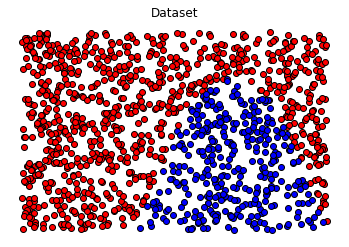

In [5]:
y = pd.DataFrame.from_dict(y)
y = y.iloc[:, :]
y = y[0].apply(lambda x: 1 if x <= 0 else 0)
y = y.to_numpy()
#y_hot = tf.keras.utils.to_categorical(y, num_classes=2)  # one-hot encoded labels
#Normalize from 0 to pi
from sklearn.preprocessing import StandardScaler , minmax_scale
X = minmax_scale(X, feature_range=(0, np.pi))
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(X[:, 0][y == 0], X[:, 1][y == 0], c="r", marker="o", edgecolors="k")
plt.scatter(X[:, 0][y == 1], X[:, 1][y == 1], c="b", marker="o", edgecolors="k")
plt.title("Dataset")
plt.axis('off')
plt.show()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)

## 3. Build Quantum node

### Blocks: AngleEmbedding and StronglyEntanglingLayers is one block 
### Layers: multiple “layers” of StronglyEntanglingLayers per block 

In [6]:
# Define quantum node
dev = qml.device("default.qubit.tf", wires=n_qubits) # Run the model in classical CPU
qml.enable_tape() #enable tape mode. Tape mode must be disabled to run in a QPU

@qml.qnode(dev, interface="tf", grad_method="backprop")
def qnode(inputs, weights):
    for i in range(blocks):
        qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
        qml.templates.StronglyEntanglingLayers(weights[i], wires=range(n_qubits)) #STRONGLY ENTANGLING LAYERS
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

weights_shape = (blocks, layers, n_qubits, 3) # Uncomment for Strongly entangling layers

## 4. Building and Training the Hybrid model:

In [7]:
tf.keras.backend.set_floatx("float64")
weight_shapes = {"weights": weights_shape}

# Create the Hybrid model
#------------ classical Master layer ------------
clayerM = tf.keras.layers.Dense(X_train.shape[1], activation="relu") 
#------------ Quantum layer. It consists of the quantum node as defined before ------------
qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, n_qubits)
#------------ Classical Decision layer ------------
clayerD = tf.keras.layers.Dense(1, activation="sigmoid")
#--------------------------------------------------

inputs = tf.constant(np.random.random((batch_size, n_qubits)))

# Include classical and quantum layers 
modelh = tf.keras.models.Sequential([clayerM,qlayer,clayerD])


modelh.compile(opt, loss='binary_crossentropy',
               metrics=[AUC(name = 'auc')])#'sparse_categorical_accuracy','categorical_accuracy','binary_accuracy', 'accuracy'])

modelh.build(input_shape=X_train.shape)

historyh = modelh.fit(X_train, y_train,
                      #validation_split = 0.1,    
                      validation_data=(X_test, y_test),
                      epochs=epochsH,
                      batch_size=batch_size,
                     shuffle=True)

modelh.summary()

Epoch 1/6
60/60 [==============================] - 69s 1s/step - loss: 0.4491 - auc: 0.8547 - val_loss: 0.4208 - val_auc: 0.9329
Epoch 2/6
60/60 [==============================] - 70s 1s/step - loss: 0.3801 - auc: 0.8931 - val_loss: 0.3241 - val_auc: 0.9483
Epoch 3/6
60/60 [==============================] - 69s 1s/step - loss: 0.3323 - auc: 0.9162 - val_loss: 0.2728 - val_auc: 0.9808
Epoch 4/6
60/60 [==============================] - 69s 1s/step - loss: 0.2586 - auc: 0.9609 - val_loss: 0.1807 - val_auc: 0.9937
Epoch 5/6
60/60 [==============================] - 70s 1s/step - loss: 0.1684 - auc: 0.9863 - val_loss: 0.1033 - val_auc: 0.9988
Epoch 6/6
60/60 [==============================] - 70s 1s/step - loss: 0.1972 - auc: 0.9716 - val_loss: 0.0940 - val_auc: 0.9985
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2)                 6         
________

## 5. Make predictions and plot training history + prediction grids

In [8]:
# Make predictions 
y_pred = modelh.predict_proba(X_test)

C:\Users\Quantum\anaconda3\envs\Quantum\lib\site-packages\tensorflow\python\keras\engine\sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


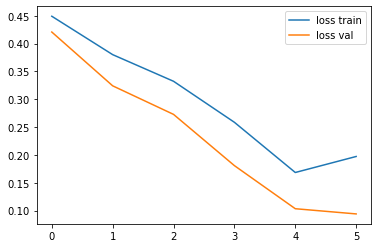

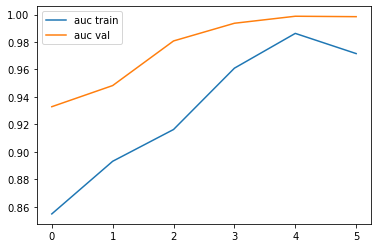

In [9]:
from matplotlib import pyplot
pyplot.plot(historyh.history['loss'], label='loss train')
pyplot.plot(historyh.history['val_loss'], label='loss val')
pyplot.legend()
pyplot.show()

#pyplot.plot(historyh.history['binary_accuracy'], label='accuracy train')
#pyplot.plot(historyh.history['val_binary_accuracy'], label='accuracy test')
#pyplot.plot(history.history['mse'], label='mse')
#pyplot.plot(history.history['mae'], label='mae')
#pyplot.legend()
#pyplot.show()

pyplot.plot(historyh.history['auc'], label='auc train')
pyplot.plot(historyh.history['val_auc'], label='auc val')
pyplot.legend()
pyplot.show()

In [10]:
y_pred = modelh.predict_classes(X_test)
from numpy import arange, meshgrid, hstack
plt.figure()
cm = plt.cm.RdBu_r
fig= plt.figure(figsize=(15,15))
# make data for decision regions
# define bounds of the domain
min1, max1 = X_test[:, 0].min()-0.2, X_test[:, 0].max()+0.2
min2, max2 = X_test[:, 1].min()-0.2, X_test[:, 1].max()+0.2
# define the x and y scale
x1grid = arange(min1, max1, 0.1)
x2grid = arange(min2, max2, 0.1)
# create all of the lines and rows of the grid
xx, yy = meshgrid(x1grid, x2grid)
# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
# horizontal stack vectors to create x1,x2 input for the model
grid = hstack((r1,r2))
# make predictions for the grid
yhat = modelh.predict_classes(grid)
# reshape the predictions back into a grid
zz = yhat.reshape(xx.shape)

C:\Users\Quantum\anaconda3\envs\Quantum\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


<Figure size 432x288 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 432x288 with 0 Axes>

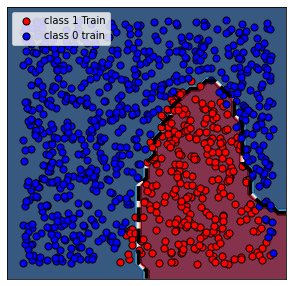

In [11]:
from numpy import arange, meshgrid, hstack
plt.figure()
fig= plt.figure(figsize=(5,5))
cm = plt.cm.RdBu_r
# plot decision regions
cnt = plt.contourf(xx, yy,zz, levels=np.arange(0, 1, 0.1), cmap=cm, alpha=0.8, extend="both")
plt.contour(xx, yy,zz, levels=[0.5], colors=("black",), linestyles=("--",), linewidths=(4.0,))


# plot data
plt.scatter(
    X_train[:, 0][y_train == 1],
    X_train[:, 1][y_train == 1],
    c="r",s=50,
    marker="o",
    edgecolors="k",
    label="class 1 Train",
)
plt.scatter(
       X_train[:, 0][y_train == 0],
       X_train[:, 1][y_train == 0],
    c="b",
    marker="o",s=50,
    edgecolors="k",
    label="class 0 train",
)

plt.title(label=LABELplot,
          fontsize=12,
          color="Black")
plt.xlabel('')
plt.ylabel('')
plt.legend(loc='upper left',fontsize=10)
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
plt.show()

In [12]:
from sklearn.metrics import accuracy_score
print("Test Accuracy = ",accuracy_score(y_test, y_pred))

Test Accuracy =  0.9791666666666666
